In [1]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os

import numpy as np
import pandas as pd
import scanpy as sc

import torch
import pyro

from spexlvm.models import Spex
from spexlvm.utils import get_pathways, compute_factor_relevance, test_refinement
from spexlvm.plotting import plot_factor_relevance

<IPython.core.display.Javascript object>

In [3]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f55b4d85d50>


<IPython.core.display.Javascript object>

In [4]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={"lines.linewidth": 2},
)

<IPython.core.display.Javascript object>

Set the first available GPU to visible if training on a machine with multiple GPUs

In [5]:
from spexlvm.utils import get_free_gpu_idx

try:
    gpu_idx = get_free_gpu_idx()
    print("Using GPU:%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU:2


<IPython.core.display.Javascript object>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = str(device) == "cuda"

if use_cuda:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

cuda


<IPython.core.display.Javascript object>

Here we investigate a larger dataset of peripheral blood mononuclear cells from lupus patients profiled from droplet single-cell RNA-sequencing (dscRNA-seq) from Kang et al., [2017](https://doi.org/10.1038/nbt.4042), where cells were either stimulated with Interferon-$\beta$ or left untreated, yielding two similarly sized groups of cells. We adopt the preprocessing steps from Rybakov et al., [2020](https://doi.org/10.1101/2020.12.02.401182), resulting in a dataset of 13,576 samples, each comprising 979 features or genes.

In [7]:
adata = sc.read(os.path.join("..", "dataset", "kang_17.h5ad"))
adata.X -= adata.X.mean(0)

<IPython.core.display.Javascript object>

Load the pathways from the molecular signatures database, [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb). Additional parameters filter too small or too large pathways.

In [8]:
pathways = get_pathways(adata.var_names, ["reactome"])

Loading collection reactome with at least 10.0% of genes available and at least 15 genes
Adding 131 pathways from reactome collection with median size of 25.0 genes
Loaded in total 131 pathways with a median size of 25.0


<IPython.core.display.Javascript object>

Match the loaded pathways with the available genes (features) and generate a binary pathway mask of dimensions $K \times D$, where $K$ is the number of factors and $D$ is the number of genes. Store the results into the loaded AnnData for convenience.

In [9]:
pathway_mask, pathway_list = pathways.to_mask(adata.var_names, sort=True)

adata.uns["pathway_names"] = [p.name for p in pathway_list]
adata.varm["pathway_mask"] = pd.DataFrame(
    pathway_mask.T,
    index=adata.var_names,
    columns=adata.uns["pathway_names"],
)

<IPython.core.display.Javascript object>

Initialise spex-LVM and provide the necessary parameters such as the number of features, number of factors (annotated, sparse, dense), etc. Subsequently, build the model by passing the AnnData object.

In [10]:
model = Spex(
    n_features=adata.n_vars,
    n_annotated=len(adata.uns["pathway_names"]),
    likelihood="normal",
    global_prior_scale=0.1,
    factor_scale_on=True,
    use_cuda=use_cuda,
)

model.build(adata)

True

<IPython.core.display.Javascript object>

In [11]:
# set random seed
pyro.set_rng_seed(20012022)

# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

Cleaning parameter store


<IPython.core.display.Javascript object>

In [12]:
loss_history, _ = model.fit(
    batch_size=1000,
    n_iterations=3000,
    learning_rate=0.001,
)

2022-01-26 17:47:58 - INFO - Using batches of size 1000
100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:31<00:00, 32.86it/s, ELBO=2.85e+3]


<IPython.core.display.Javascript object>

In [13]:
model.fill_adata()
adata

AnnData object with n_obs × n_vars = 13576 × 979
    obs: 'label', 'batch'
    uns: 'pathway_names'
    obsm: 'X'
    varm: 'pathway_mask', 'W'

<IPython.core.display.Javascript object>

First, we compute assign a relevance score to each factor based on the variance explained ($R^2$) by the factor.

In [14]:
r2_scores, r2_acc = compute_factor_relevance(
    adata.X,
    adata.obsm["X"].values,
    adata.varm["W"].T.values,
    which="both",
)
r2_acc

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:14<00:00,  9.02it/s]


0.6982961297035217

<IPython.core.display.Javascript object>

Next, we perform a gene set enrichment analysis (GSEA) based on the PCGSE algorithm from Frost et al., [2015](https://dx.doi.org/10.1186%2Fs13040-015-0059-z) in order quantify the significance of each learned factor with respect to the prior information.

In [15]:
factors_df = pd.DataFrame({"name": adata.uns["pathway_names"], "r2": r2_scores})
for sign in ["pos", "neg"]:
    t_stat_df, prob_df, prob_adj_df = test_refinement(
        adata,
        sign=sign,
        corr_adjust=True,
    )
    factors_df[f"FDR_{sign}"] = np.clip(np.diag(prob_adj_df), a_min=1e-10, a_max=1.0)
    factors_df[f"neg_log_FDR_{sign}"] = -(np.log10(factors_df[f"FDR_{sign}"]))
    factors_df[f"sig_at_005_{sign}"] = factors_df[f"FDR_{sign}"] < 0.05

<IPython.core.display.Javascript object>

Now we can generate a visual overview of the learned factors, where each factor describes how the corresponding pathway manifests in this dataset. We sort all factors based on the variance explained. The size of each dot encodes how well each factor matches the prior information, while the color serves as an indicator whether the factor is significant at $\alpha = 0.05$. Notice that we perform the GSEA twice, first taking into consideration only positive factor loadings, then only negative factor loadings, as a mixture of both positive and negative loadings during testing can lead to less significant results.

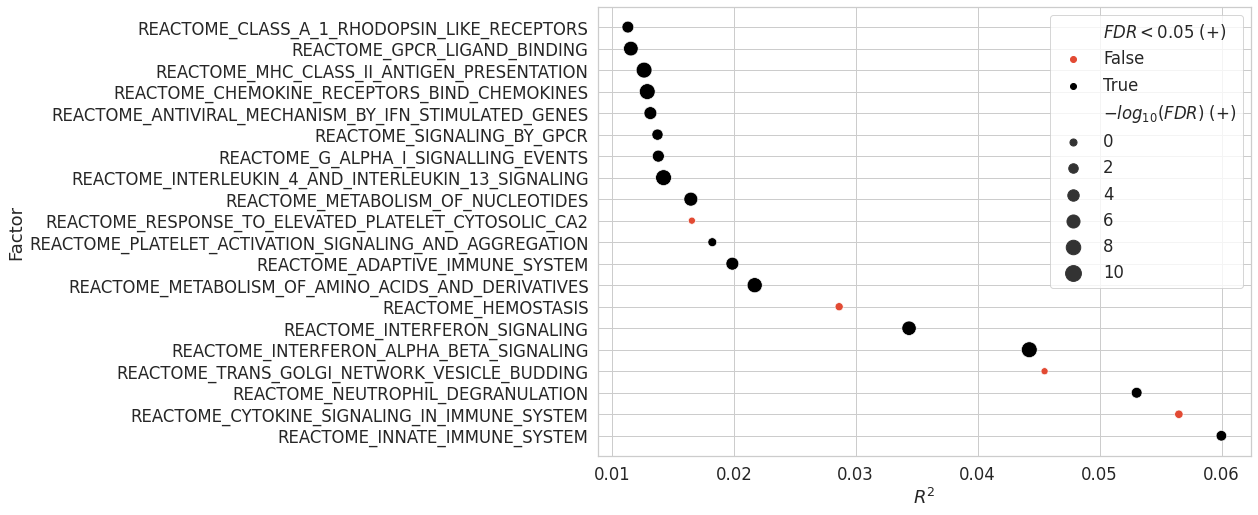

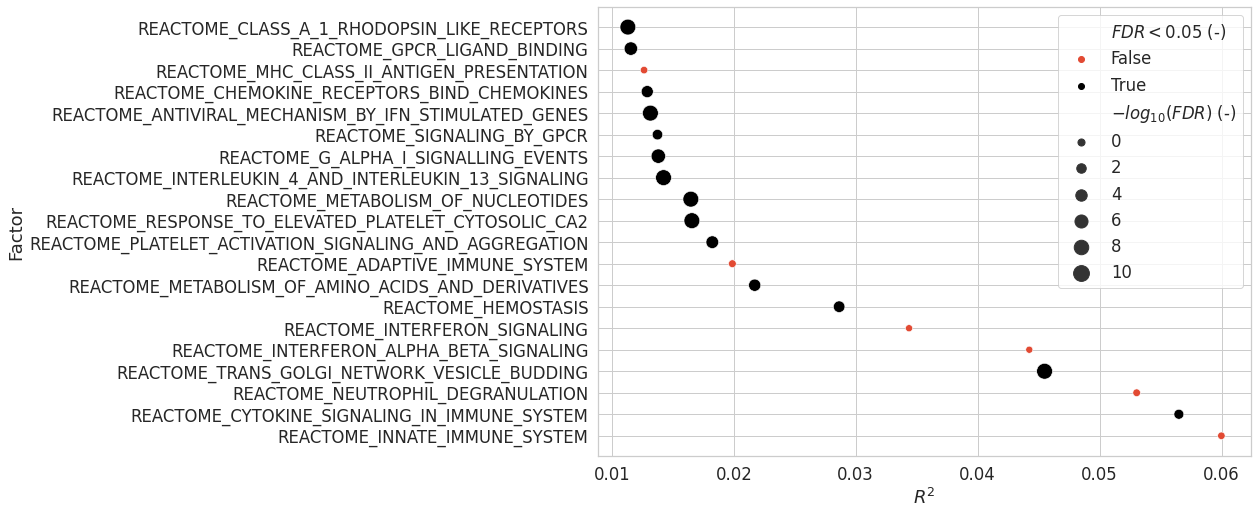

<IPython.core.display.Javascript object>

In [16]:
black = "#000000"
red = "#e24a33"
rename_dict = {
    "sig_at_005_pos": r"$FDR < 0.05$ (+)",
    "neg_log_FDR_pos": r"$-log_{10}(FDR)$ (+)",
    "sig_at_005_neg": r"$FDR < 0.05$ (-)",
    "neg_log_FDR_neg": r"$-log_{10}(FDR)$ (-)",
}

for sign in ["pos", "neg"]:
    g = plot_factor_relevance(
        factors_df,
        xlabel="r2",
        ylabel="name",
        top_k=20,
        hue=f"sig_at_005_{sign}",
        palette={True: black, False: red},
        size=f"neg_log_FDR_{sign}",
        sizes=(50, 250),
    )
    g.set(xlabel=r"$R^2$", ylabel="Factor")
    handles, labels = g.get_legend_handles_labels()

    g.legend(
        handles=handles,
        labels=[l if l not in rename_dict else rename_dict[l] for l in labels],
    )
    plt.show()

We mainly observe pathways related to immune system and interferon response. We expect interferon signaling and interferon alpha beta signaling to capture the transcriptomic differences between the control and stimulated group.
On the other hand, pathways involved in the immune response should explain the main drivers of variation along the different cell types. In addition, we observe relatively smaller, yet more specific pathways such as the signaling by the B cell receptor and the MHC class II antigen presentation, which reveal less represented cell types such as B cells and dendritic cells.

In [17]:
if_pathways = [
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    "REACTOME_INTERFERON_SIGNALING",
]

im_pathways = [
    "REACTOME_INNATE_IMMUNE_SYSTEM",
    "REACTOME_NEUTROPHIL_DEGRANULATION",
    "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
    "REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION",
]

for rv in if_pathways + im_pathways:
    adata.obs[rv] = adata.obsm["X"][rv].copy()

<IPython.core.display.Javascript object>

In [18]:
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)

<IPython.core.display.Javascript object>

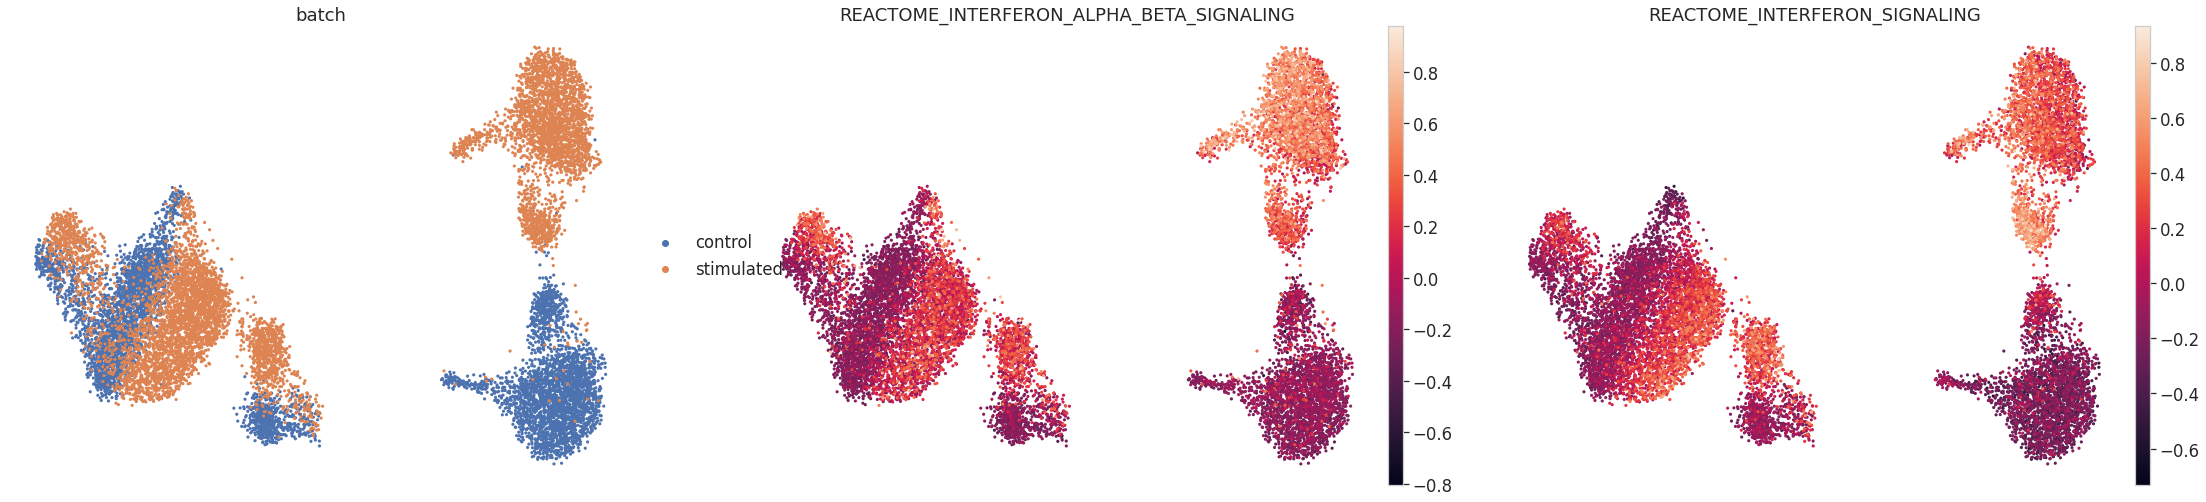

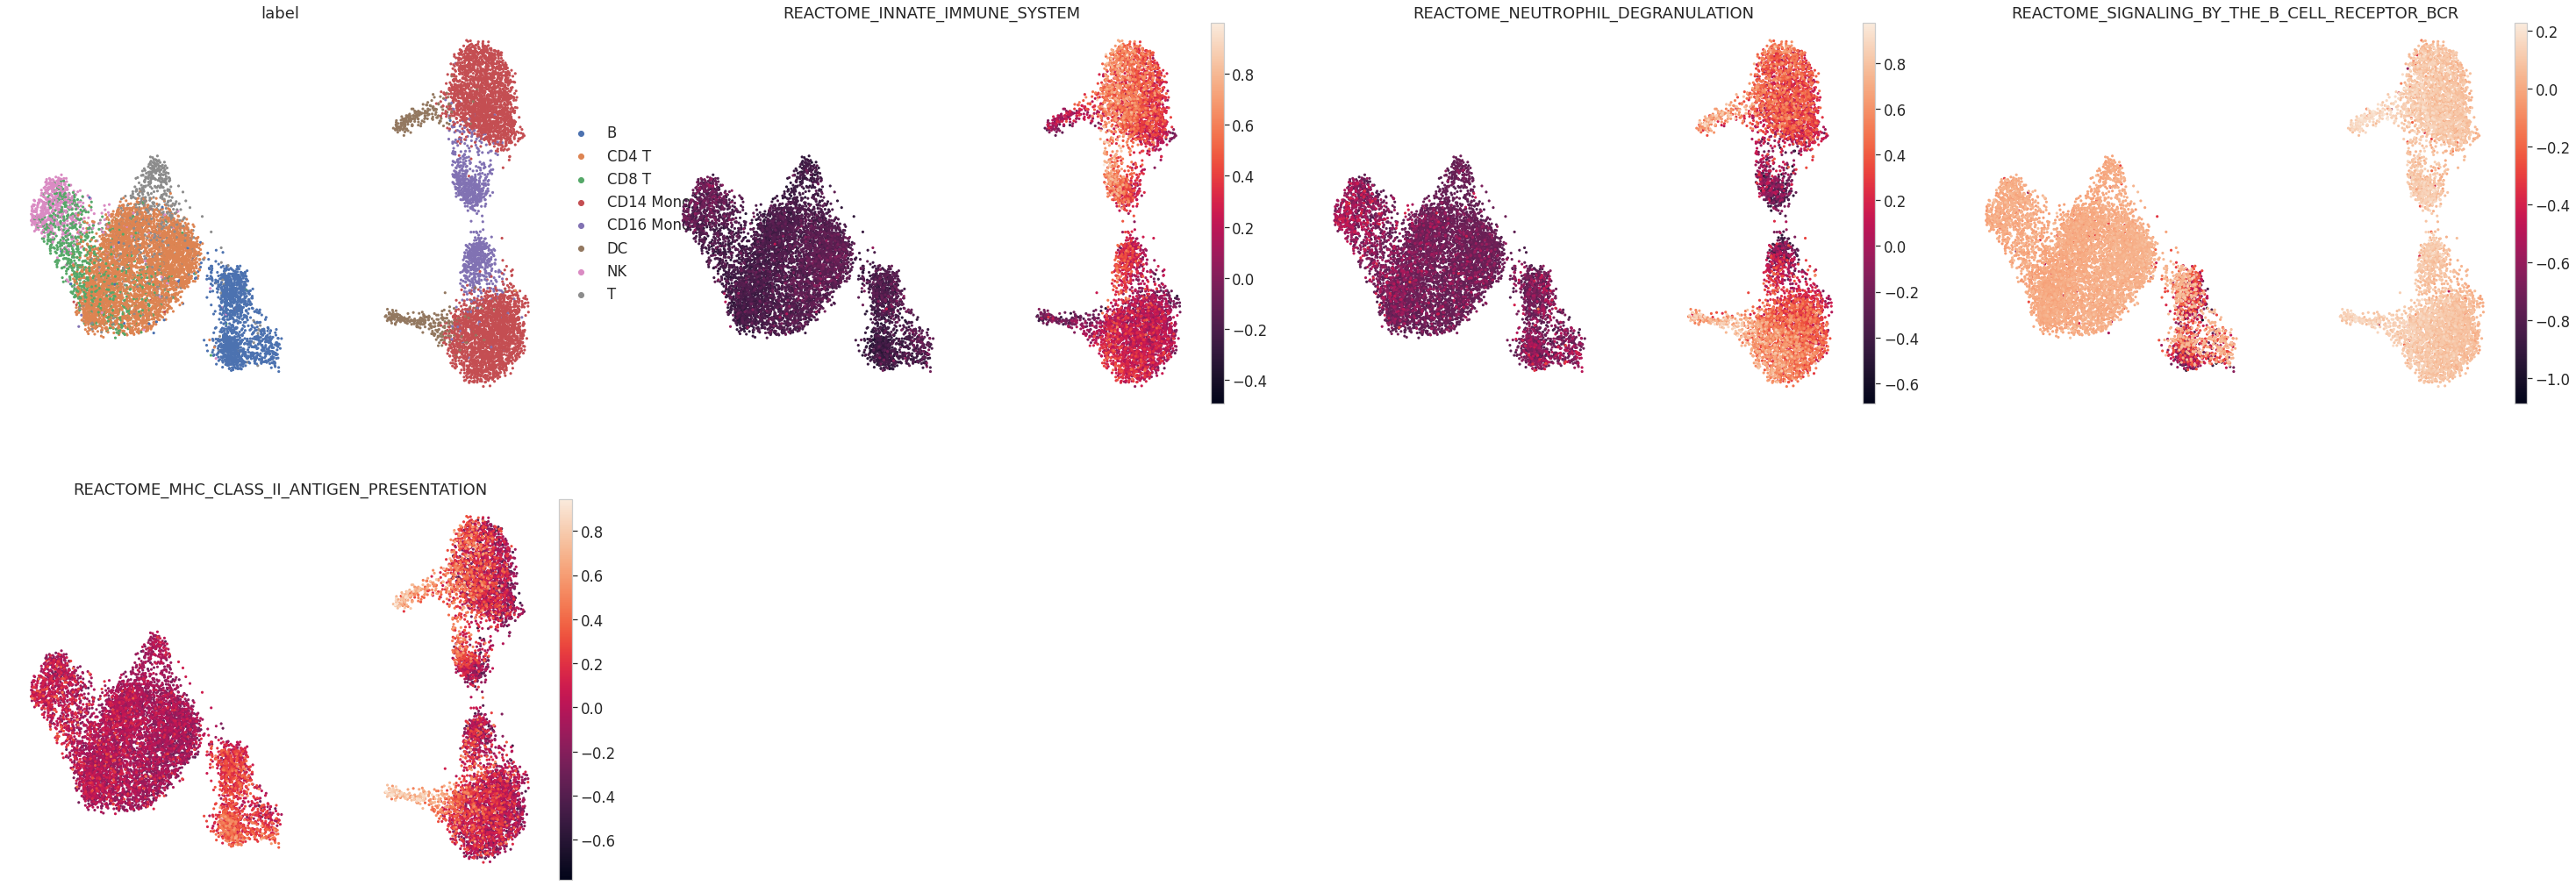

<IPython.core.display.Javascript object>

In [19]:
label = "label"
batch = "batch"

sc.pl.umap(
    adata,
    color=[batch] + if_pathways,
    frameon=False,
    size=40,
)

sc.pl.umap(
    adata,
    color=[label] + im_pathways,
    frameon=False,
    size=40,
)

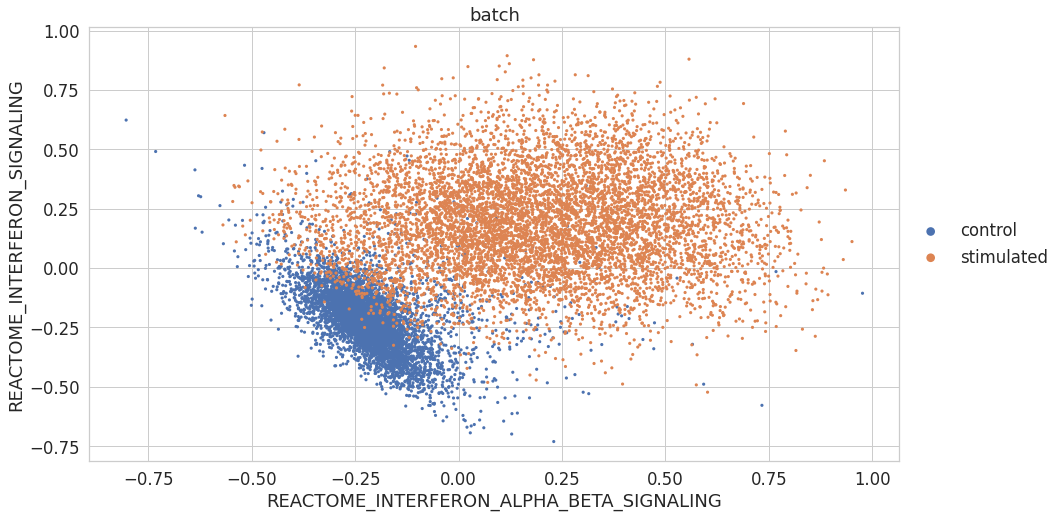

<IPython.core.display.Javascript object>

In [20]:
sc.pl.scatter(
    adata,
    x="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    y="REACTOME_INTERFERON_SIGNALING",
    color=batch,
    size=40,
)

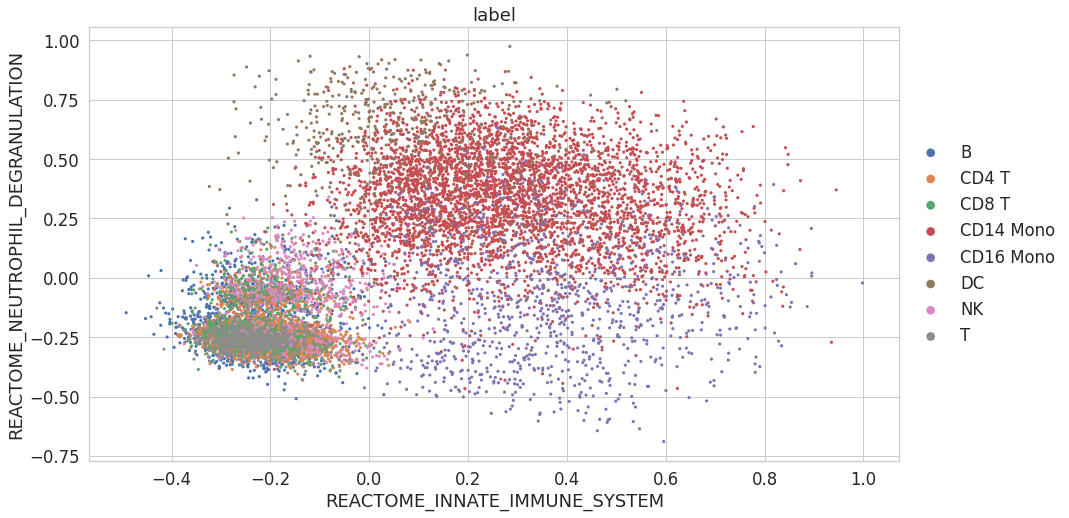

<IPython.core.display.Javascript object>

In [21]:
sc.pl.scatter(
    adata,
    x="REACTOME_INNATE_IMMUNE_SYSTEM",
    y="REACTOME_NEUTROPHIL_DEGRANULATION",
    color=label,
    size=40,
)

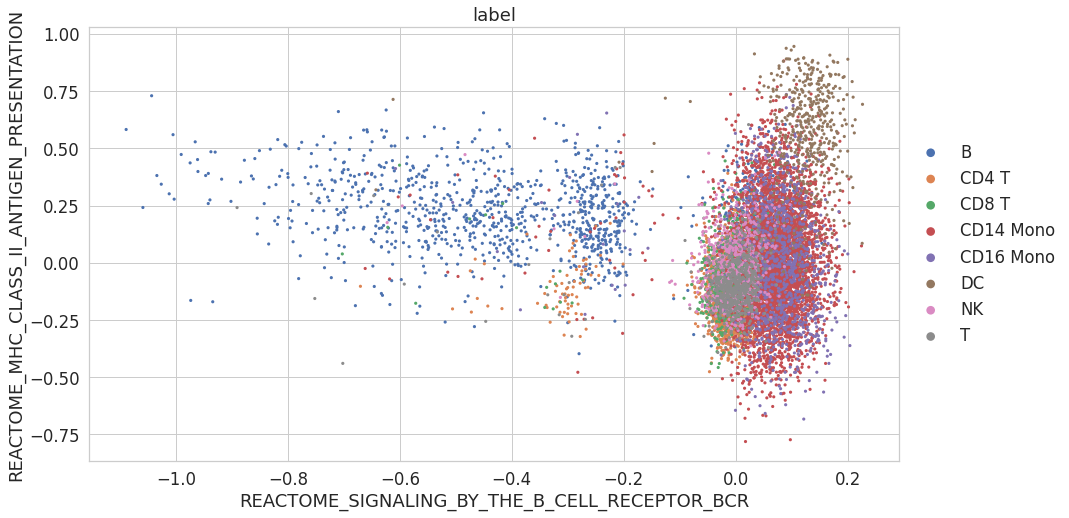

<IPython.core.display.Javascript object>

In [22]:
sc.pl.scatter(
    adata,
    x="REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
    y="REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION",
    color=label,
    size=40,
)

In [23]:
# adata.write('adata.h5ad')

<IPython.core.display.Javascript object>